In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import csv

from tkmodel.TwoCUM_copy import TwoCUMfittingConc
from tkmodel.TwoCUM_copy import TwoCUM

In [6]:
AIF = np.load("data/AIF.npy")
series = np.load("data/Example_Conc.npy")
t = np.arange(0,366,2.45)


In [7]:
def E_distribution(num):
    p = 0.09392265193370165
    params = (69.70266807226483, 1.0792465008741048, -0.23357477054649745, 0.08955766184221467)
    start_nums = int(p*num)
    
    start = np.random.uniform(low = 0, high= 0.001, size = start_nums)
    
    dist_num = num - start_nums
    gen_data_Fp = st.exponweib.rvs(params[0], params[1], params[2], params[3], size=dist_num)
    gen_data_Fp = np.array(gen_data_Fp)
    
    true_dist = np.concatenate((start, gen_data_Fp), axis=None)
    
    true_dist[true_dist < 0] = 0.0001

    
    
    return true_dist

def Fp_distribution(num):
    p = 0.1182
    params = (1.064799958220838, 0.0005001496965058328, 0.007151833882619035)
    start_nums = int(p*num)
    
    start = np.random.uniform(low = 0, high= 0.0005, size = start_nums)
    
    dist_num = num - start_nums
    gen_data_Fp = st.weibull_min.rvs(params[0], params[1], params[2], size=dist_num)
    gen_data_Fp = np.array(gen_data_Fp)
    
    true_dist = np.concatenate((gen_data_Fp, start), axis=None)
    #true_dist[true_dist > 1] = 0.99

    
    
    return true_dist

def vp_distrubition(num):
    params = (29572479.030125827, 6450136.935704315, 6450136.715197781)
    p = 0.287
    endnum = int(p*num)
    end = np.random.uniform(low = 0.98, high= 0.99, size = endnum)
    
    dist_num = num - endnum
    gen_data_vp = st.weibull_max.rvs(params[0], params[1], params[2], size=dist_num)
    gen_data_vp = np.array(gen_data_vp)
    
    true_dist = np.concatenate((gen_data_vp, end), axis=None)
    true_dist[true_dist > 1] = 0.99
    true_dist[true_dist < 0] = 0.011

    
    
    return true_dist

In [8]:
def generate_xy(num_curves):
    AIF = np.load("data/AIF.npy")
    data_size = AIF.shape[0]
    t = np.arange(0,366,2.45)

    #E = np.random.rand(1,num_curves) #0 to 1 for both E and vp
    #vp = np.random.rand(1,num_curves)
    #Fp = np.random.rand(1,num_curves) #this will be multplied by 1e-5 to get the right scale at the end
    
    E = E_distribution(num_curves) 
    Fp = Fp_distribution(num_curves)
    vp = vp_distrubition(num_curves)

    E = E[None,:]
    Fp = Fp[None,:]
    vp = vp[None,:]



    
    E_Fp = np.concatenate((E, Fp), axis =0)
    y = np.concatenate((E_Fp, vp), axis =0)


    x = np.zeros((num_curves, data_size))
    for i in range(num_curves):
        x[i] = TwoCUM(y[:,i], t, AIF, 0)

    y = y.T 
    
    return x,y

In [9]:
E = np.load('data/E_list_uterus.npy')

Fp = np.load('data/Fp_list_uterus.npy')

vp = np.load('data/vp_list_uterus.npy')

index = np.load('data/index_uterus.npy')

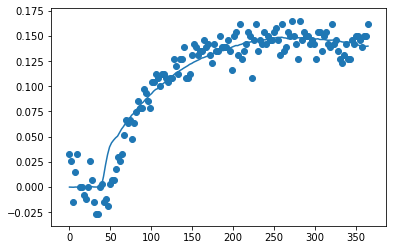

In [10]:
ind = 9
curve = TwoCUM([E[ind], Fp[ind], vp[ind]], t, AIF, 0)
real_data = series[index[ind][0], index[ind][1], index[ind][2], :]
plt.plot(t, curve)
plt.scatter(t, real_data)


In [11]:
def std(list1, list2):
    if list1.shape != list2.shape:
        print('not the same size')
    difference = (list1 - list2)**2
    std = np.sum(difference) / list1.shape[0]

    min_ = difference.min()
    
    max_ = difference.max()
    
    return std, (min_, max_)
    

In [12]:
std(real_data, curve)

(0.0002093080540882591, (1.9749296321314334e-08, 0.0026129132360380274))

In [13]:
std_list = []
max_list = []
min_list = []
for i in range(len(index)):
    curve = TwoCUM([E[i], Fp[i], vp[i]], t, AIF, 0)
    real_data = series[index[i][0], index[i][1], index[i][2], :]
    st, min_max = std(real_data, curve)
    std_list.append(st)
    min_list.append(min_max[0])
    max_list.append(min_max[1])

    


In [14]:
a = np.array(std_list)
outliers = np.where(a > 1)
std_mean = a.mean()

std_mean, a.max(), a.min()

(248.91758411835525, 127978.34601565209, 4.532755650418952e-07)

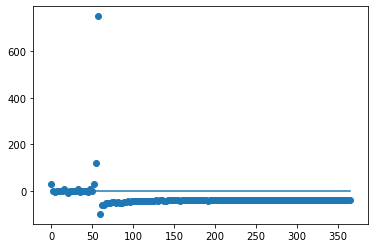

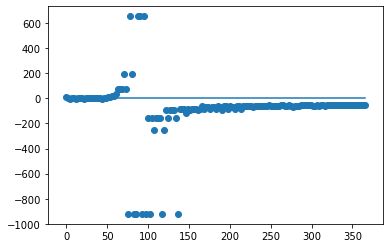

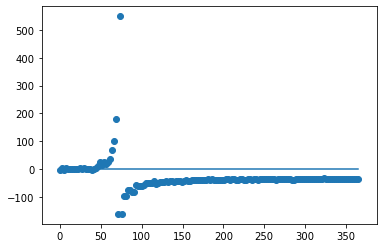

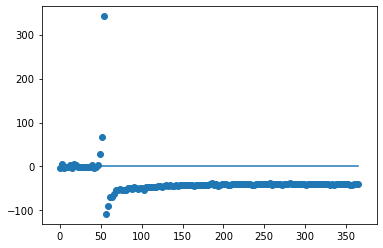

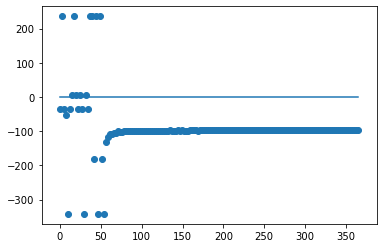

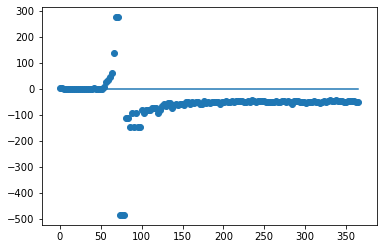

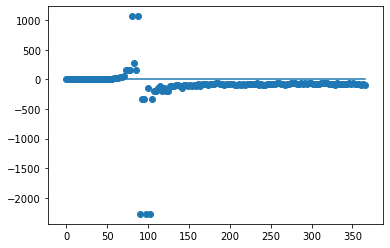

<Figure size 432x288 with 0 Axes>

In [15]:

for i in outliers[0]:
    curve = TwoCUM([E[i], Fp[i], vp[i]], t, AIF, 0)
    real_data = series[index[i][0], index[i][1], index[i][2], :]
    plt.plot(t, curve)
    plt.scatter(t, real_data)
    plt.show()
    plt.clf()
    


In [16]:
std_mean = a[a<1].mean()
std_std = np.std(a[a<1])

std_mean, std_std, a[a<1].min(), a[a<1].max()

(0.015483295177018167,
 0.030634380803297348,
 4.532755650418952e-07,
 0.22447285506027184)

No handles with labels found to put in legend.


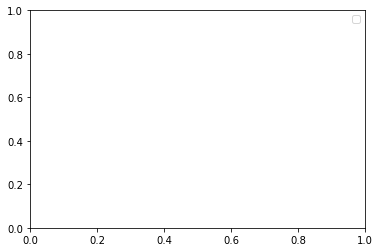

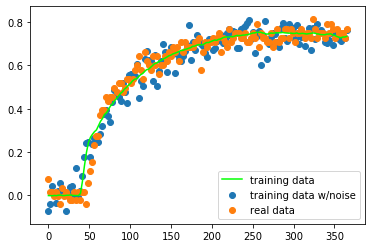

<Figure size 432x288 with 0 Axes>

In [35]:
std_mean = 0.015483295177018167
noise = np.random.normal(scale = 3.7*std_mean, size =150)
ind = 25
curve = TwoCUM([E[ind], Fp[ind], vp[ind]], t, AIF, 0)
real_data = series[index[ind][0], index[ind][1], index[ind][2], :]
# plt.plot(t, curve)
plt.legend()
# plt.savefig('plots/real_data_scatter')
plt.show()
plt.clf()

fake_data = curve + noise*curve.max()
plt.plot(t, curve, color ='lime', label = 'training data')
plt.scatter(t, fake_data, label = 'training data w/noise')
plt.scatter(t, real_data, label = 'real data')
plt.legend()
plt.savefig('plots/training_data_w_noise_'+str(ind))
plt.show()
plt.clf()

In [17]:
print(a[a<1].argmax())


ind = 354
curve = TwoCUM([E[ind], Fp[ind], vp[ind]], t, AIF, 0)
real_data = series[index[ind][0], index[ind][1], index[ind][2], :]
plt.plot(t, curve)
plt.scatter(t, real_data)
plt.show()
plt.clf()


noise = np.random.normal(scale = std_mean, size =150)
fake_data = curve
plt.plot(t, curve)
plt.scatter(t, fake_data)
plt.show()
plt.clf()

NameError: name 'a' is not defined

In [125]:
'''Find it scaled for how large the curves get'''

std_list = []
max_list = []
min_list = []

scaled_std_list = []

for i in range(len(index)):
    curve = TwoCUM([E[i], Fp[i], vp[i]], t, AIF, 0)
    real_data = series[index[i][0], index[i][1], index[i][2], :]
    st, min_max = std(real_data, curve)
    std_list.append(st)
    min_list.append(min_max[0])
    max_list.append(min_max[1])
    scaled_std_list.append(curve.max()*st)
    


In [135]:
scaled_std_list = np.array(scaled_std_list)
print(np.where(scaled_std_list > 0.8)[0])
print(outliers[0])
scaled_std_list.mean(), scaled_std_list.max(), scaled_std_list.min()

[355 447 498 562 677 786 791 881]
[249 498 659 782 791 795 881]


(0.06150879935934834, 7.666486508243676, 1.4329178576827919e-09)

In [4]:
enc_sizes = [1, 32, 64]

a = [(in_f, out_f) for in_f, out_f in zip(enc_sizes, enc_sizes[1:])]
a

[(1, 32), (32, 64)]